In [1]:
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from sklearn.model_selection import train_test_split

In [2]:
img_name = "davis.jpg"
img_path = os.path.join("./test", img_name)

In [3]:
vgg = VGG16()

model = Model(inputs = vgg.inputs, outputs = vgg.layers[-2].output)
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [4]:
test_features = {}

image = load_img(img_path, target_size = (224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = model.predict(image, verbose = 0)
image_id = img_name.split(".")[0]
test_features[image_id] = feature

In [5]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [6]:
# Predicts caption for images
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [7]:
with open(os.path.join("./archive_og", 'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

# Cleans the captions
def clean(mapping):
    for id, captions in mapping.items():
        for x in range(len(captions)):
            caption = captions[x]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = " ".join(caption.split())
            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[x] = caption

clean(mapping)

all_cap = []
for key in mapping:
    for caption in mapping[key]:
        all_cap.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [8]:
from tensorflow.keras.models import load_model
new_model = load_model('./best_model.keras')

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("./test", image_name)
    image = Image.open(img_path)
    # predict the caption
    max_length = 35
    y_pred = predict_caption(new_model, test_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return y_pred

--------------------Predicted--------------------
startseq man rides bike through the air over large dirt ramp endseq


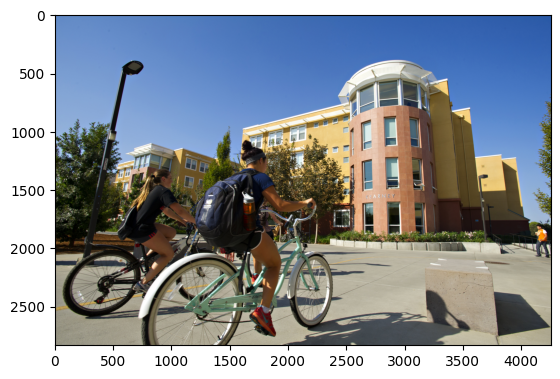

In [10]:
caption_tested = generate_caption(img_name)

In [11]:
# Add all caption words to all_cap_and_test and makes the caption lowercase
caption_words = ' '.join(caption_tested.split()[1:-1])
all_cap_and_test = all_cap.copy()
all_cap_and_test.append(caption_words)
all_cap_lower = [x.lower() for x in all_cap_and_test]
print(all_cap_lower[-1])

man rides bike through the air over large dirt ramp


In [12]:
# Creates a list with the words in the caption
arr = []
arr = all_cap_lower[-1].split(" ")
print(arr)

['man', 'rides', 'bike', 'through', 'the', 'air', 'over', 'large', 'dirt', 'ramp']


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vec = TfidfVectorizer()
X = tfid_vec.fit_transform(all_cap_lower)

In [14]:
from emoji_translate.emoji_translate import Translator
# Removes unneeded endings for words and makes exceptions for certain words
emojii = Translator(exact_match_only = False, randomize = True)
cap_vocab = tfid_vec.get_feature_names_out()[np.nonzero(X.toarray()[-1])]
for i, word in enumerate(cap_vocab):
    if word.endswith("ss"):
        cap_vocab[i] = word
    else:
        if word.endswith("s"):
            cap_vocab[i] = word[:-1] 
    if word.endswith("es"):
        cap_vocab[i] = word[:-1]
    elif word.endswith("ing"):
        cap_vocab[i] = word[:-3]
    elif word.endswith("ed"):
        if word == "red":
            break
        cap_vocab[i] = word[:-2]
    elif word.endswith("y"):
        if word == "boy":
            break
        cap_vocab[i] = word[:-1]
    
print(cap_vocab)

['air' 'bike' 'dirt' 'large' 'man' 'over' 'ramp' 'ride' 'the' 'through']


In [15]:
import emoji
# Modifies colors to be identified as certain heart emojis and emojifies words that corresponds with emojis
colors = ["red", "orange", "yellow", "green", "blue", "purple", "white", "black", "brown"]
caption_emoji = []
for word in cap_vocab:
    if word in colors:
        if word == "red":
            word = emoji.emojize(":heart:")
        else:
            word = emoji.emojize(":" + word +"_heart:")
    caption_emoji.append(emojii.emojify(word))

print(caption_emoji)

['💨', '🚲', 'dirt', 'large', '👨', 'over', 'ramp', 'ride', 'the', 'through']


In [16]:
import regex as re
# Removes non emojified words and removes emoji unicode
copy_caption_emoji = caption_emoji.copy()

for i, word in enumerate(caption_emoji):
    graphemes = re.findall(r'\X', word)
    result = "".join([grapheme for grapheme in graphemes if re.match(r'^\p{Emoji}(\uFE0F\u20E3?|[\p{Emoji}\u200D])*$', grapheme)])
    copy_caption_emoji[i] = result

while "" in copy_caption_emoji:
    copy_caption_emoji.remove("")

print(copy_caption_emoji)

['💨', '🚲', '👨']


In [17]:
# creates a dictionary containing the emojified words and their calculated weights
dic = {}
cap_weights = X.toarray()[-1][np.nonzero(X.toarray()[-1])]
for i, word in enumerate(cap_vocab):
    if word not in caption_emoji:
        dic[word] = cap_weights[i]


print(dic)
print(list(dic.keys()))

{'air': 0.32498592213604854, 'bike': 0.3406641029897916, 'man': 0.1927399782692146}
['air', 'bike', 'man']


In [18]:
# Function to determine the words with lowest TF-IDF scores
def pick_closest_values(arr):
    dict = {}
    for x in range(len(arr)):
        dict[list(arr.values())[x]] = x
    closest_values = sorted(dict.keys(), reverse = False)
    closest_indexes = []
    if len(arr) == 1:
        ret = [0,0,0]
        return ret
    if len(arr) == 2:
        ret = [0,1,0]
        return ret
    for x in range(len(closest_values[:3])):
        closest_indexes.append(dict[closest_values[x]])
    return closest_indexes

👨 💨 🚲


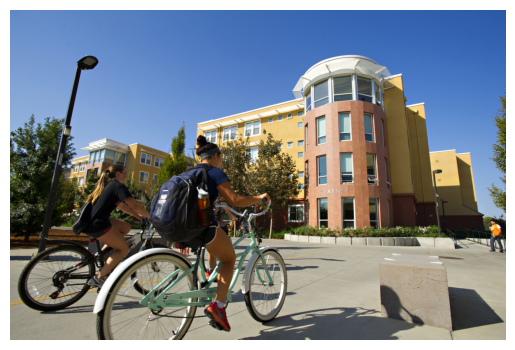

In [19]:
# Get indices of the choosen words and returns the emojis
top_indexes = pick_closest_values(dic)

top_words = []
for x in top_indexes:
    copy_caption_emoji[x] = copy_caption_emoji[x].split("\u200d")[0]
    top_words.append(copy_caption_emoji[x])
image = Image.open(img_path)
string = " ".join(map(str, top_words))

print(string)
plt.imshow(image)
plt.axis("off")
plt.show()